Dataset Overview and Cleaning

In [1]:
import sys
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## HELPER FUNCS

In [23]:
def analyze_borough_trips(df):
    # Create pivot tables for average fare and distance
    avg_fare_pivot = pd.pivot_table(
        df,
        values='fare_amount',
        index='Borough_pu',
        columns='Borough_do',
        aggfunc='mean',
        fill_value=0
    )
    
    avg_distance_pivot = pd.pivot_table(
        df,
        values='trip_distance',
        index='Borough_pu',
        columns='Borough_do',
        aggfunc='mean',
        fill_value=0
    )
    
    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Plot heatmap for fares
    sns.heatmap(avg_fare_pivot, annot=True, fmt='.0f', cmap='YlOrRd', ax=ax1)
    ax1.set_title('Average Fare Amount by Borough Routes')
    
    # Plot heatmap for distances
    sns.heatmap(avg_distance_pivot, annot=True, fmt='.1f', cmap='YlOrRd', ax=ax2)
    ax2.set_title('Average Trip Distance by Borough Routes')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\nSummary of trips between boroughs:")
    borough_counts = df.groupby(['Borough_pu', 'Borough_do']).size().reset_index()
    borough_counts.columns = ['Pickup Borough', 'Dropoff Borough', 'Number of Trips']
    print(borough_counts.sort_values('Number of Trips', ascending=False))

# 2. Box plots for fare distribution by borough pairs
def plot_fare_distributions(df):
    plt.figure(figsize=(15, 6))
    sns.boxplot(x='Borough_pu', y='fare_amount', hue='Borough_do', data=df)
    plt.title('Fare Distribution by Borough Routes')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# 3. Scatter plot of distance vs fare, colored by borough pairs
def plot_distance_vs_fare(df):
    plt.figure(figsize=(12, 8))
    for (pu, do), group in df.groupby(['Borough_pu', 'Borough_do']):
        plt.scatter(group['trip_distance'], group['fare_amount'], 
                   label=f'{pu} to {do}', alpha=0.6)
    
    plt.xlabel('Trip Distance (miles)')
    plt.ylabel('Fare Amount ($)')
    plt.title('Trip Distance vs Fare Amount by Borough Routes')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

## DATA PULLS

In [ ]:
# Import the updated DataLoader class
sys.path.append(str(Path("../src").resolve()))
from data.data_loader import DataLoader

# Define file paths
data_path = "../data/raw/yellow_tripdata_2022-05.parquet"
output_path = "../data/processed/cleaned_yellow_tripdata_2022-05.parquet"

# Initialize the DataLoader
loader = DataLoader(data_path, output_path)

# Preprocess the data (this step generates the cleaned data file)
loader.preprocess()

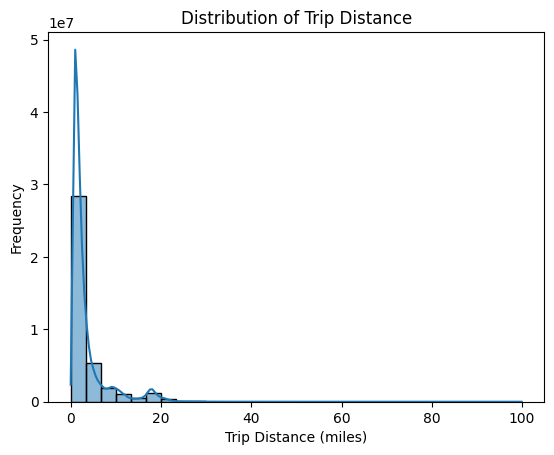

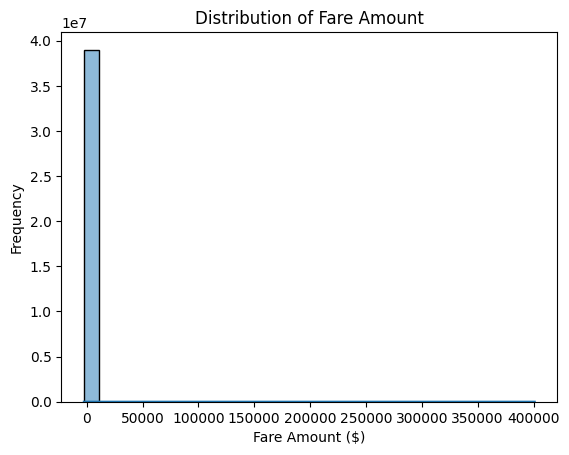

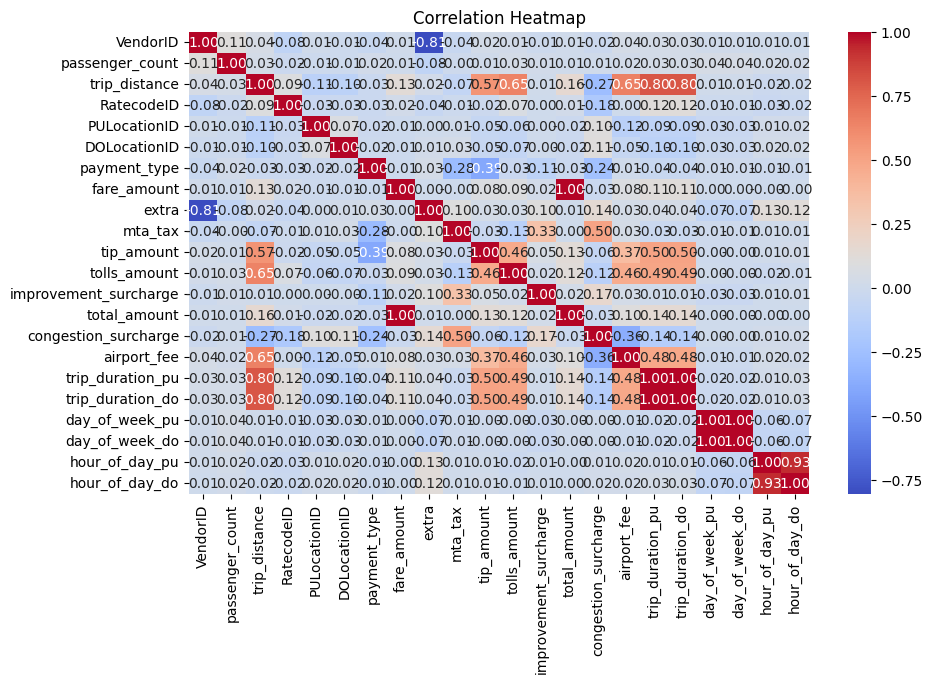

In [2]:

# Load the preprocessed data
processed_data_path = "../data/processed/yellow_processed_2022.parquet"
cleaned_df = pd.read_parquet(processed_data_path)

# Visualize the data
# Distribution of trip distance
sns.histplot(cleaned_df['trip_distance'], kde=True, bins=30)
plt.title("Distribution of Trip Distance")
plt.xlabel("Trip Distance (miles)")
plt.ylabel("Frequency")
plt.show()

# Distribution of fare amount
if 'fare_amount' in cleaned_df.columns:
    sns.histplot(cleaned_df['fare_amount'], kde=True, bins=30)
    plt.title("Distribution of Fare Amount")
    plt.xlabel("Fare Amount ($)")
    plt.ylabel("Frequency")
    plt.show()

# Correlation heatmap
numeric_df = cleaned_df.select_dtypes(include=['number'])
plt.figure(figsize=(10, 6))
sns.heatmap(numeric_df.corr(), annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap")
plt.show()



In [3]:
cleaned_df['fare_amount'].describe()

count    3.900932e+07
mean     1.465398e+01
std      9.641945e+01
min     -2.564000e+03
25%      7.000000e+00
50%      1.036000e+01
75%      1.650000e+01
max      4.010923e+05
Name: fare_amount, dtype: float64

<Axes: xlabel='trip_distance', ylabel='fare_amount'>

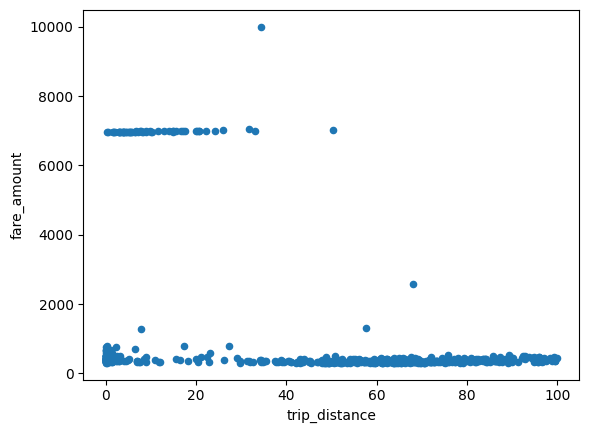

In [11]:
three_std_deviations = 1.465398e+01 + 3 * 9.641945e+01
mask_above_three_std_deviations = cleaned_df['fare_amount'] > three_std_deviations
below_crazy_fare_amount = cleaned_df['fare_amount'] < 50000

cleaned_df[mask_above_three_std_deviations & below_crazy_fare_amount].plot.scatter(x='trip_distance', y='fare_amount')

<Axes: xlabel='trip_distance', ylabel='fare_amount'>

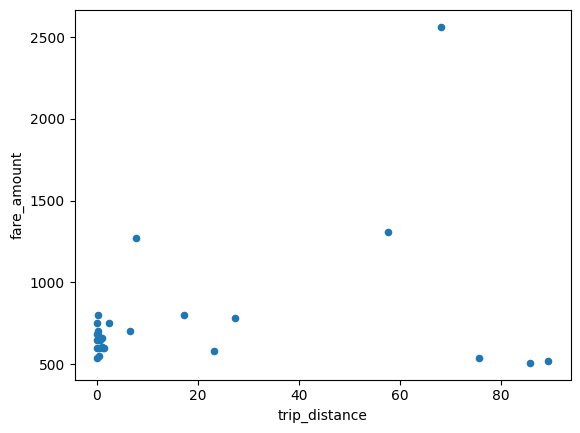

In [ ]:
mask_fares_below_7000 = cleaned_df['fare_amount'] < 6000
mask_fares_above_6000 = cleaned_df['fare_amount'] > 500
mask_initiated_outside_nyc = cleaned_df['PULocationID'] == 265
mask_dropped_outside_nyc = cleaned_df['DOLocationID'] == 265
cleaned_df[mask_fares_above_6000 & mask_fares_below_7000].plot.scatter(x='trip_distance', y='fare_amount')


In [30]:
cleaned_df[mask_fares_above_6000 & mask_fares_below_7000][['Borough_pu', 'Borough_do', 'DOLocationID', 'trip_distance', 'fare_amount']].head()

,Borough_pu,Borough_do,DOLocationID,trip_distance,fare_amount
631997,Manhattan,None,265,23.09,582.0
3878013,Queens,None,265,75.70,539.0
5184301,None,None,265,0.02,685.0
7117719,Queens,Queens,132,0.12,680.0
8069151,Queens,Queens,216,2.34,750.0


In [44]:
cleaned_df.size - cleaned_df[cleaned_df['PULocationID'] == 265].size 


1285543380

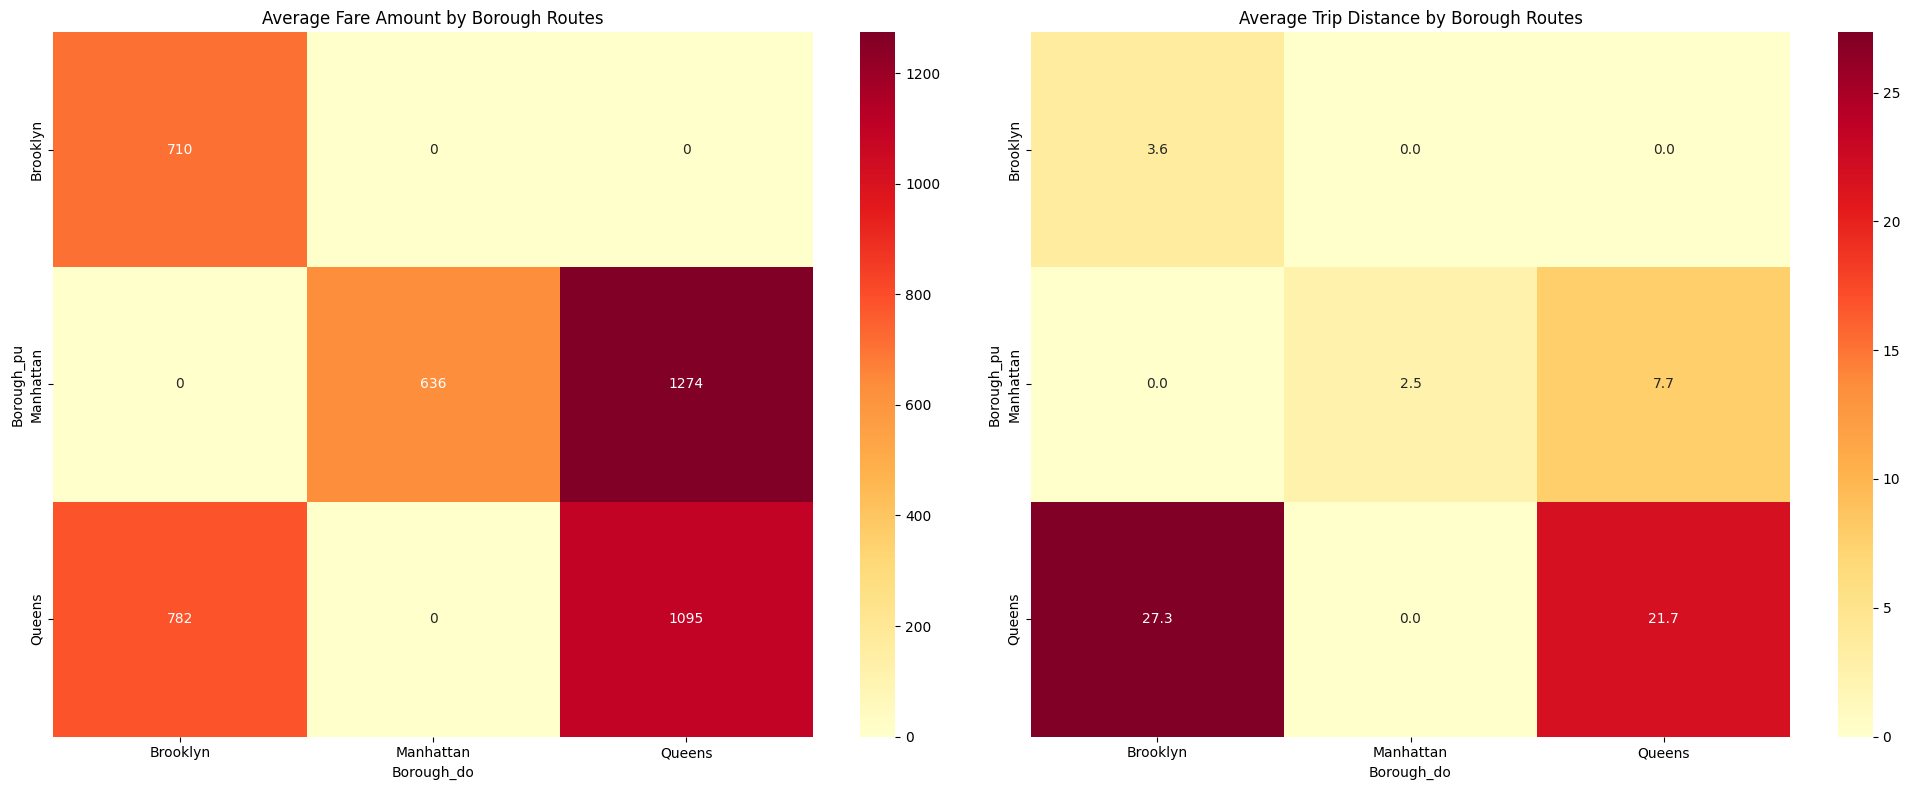


Summary of trips between boroughs:
  Pickup Borough Dropoff Borough  Number of Trips
4         Queens          Queens                6
0       Brooklyn        Brooklyn                5
1      Manhattan       Manhattan                3
2      Manhattan          Queens                1
3         Queens        Brooklyn                1


In [40]:
filtered_df = cleaned_df[mask_fares_above_6000 & mask_fares_below_7000]
analyze_borough_trips(filtered_df)

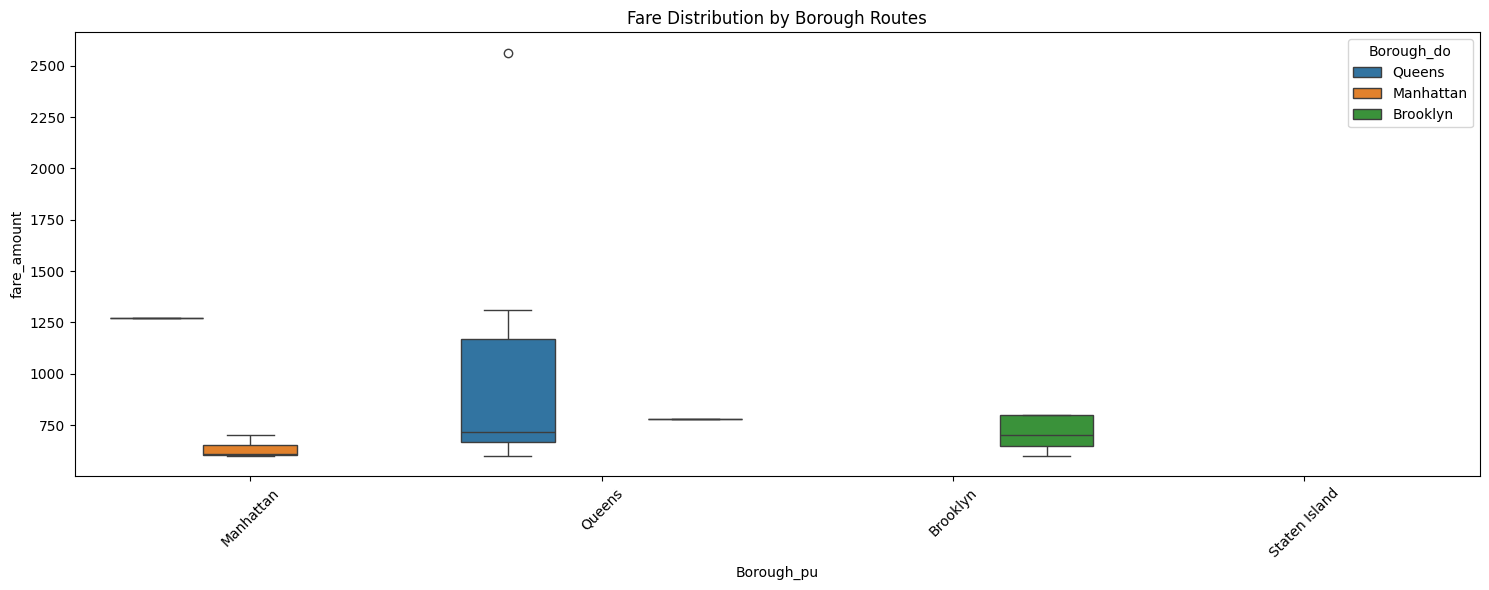

In [26]:
plot_fare_distributions(filtered_df)

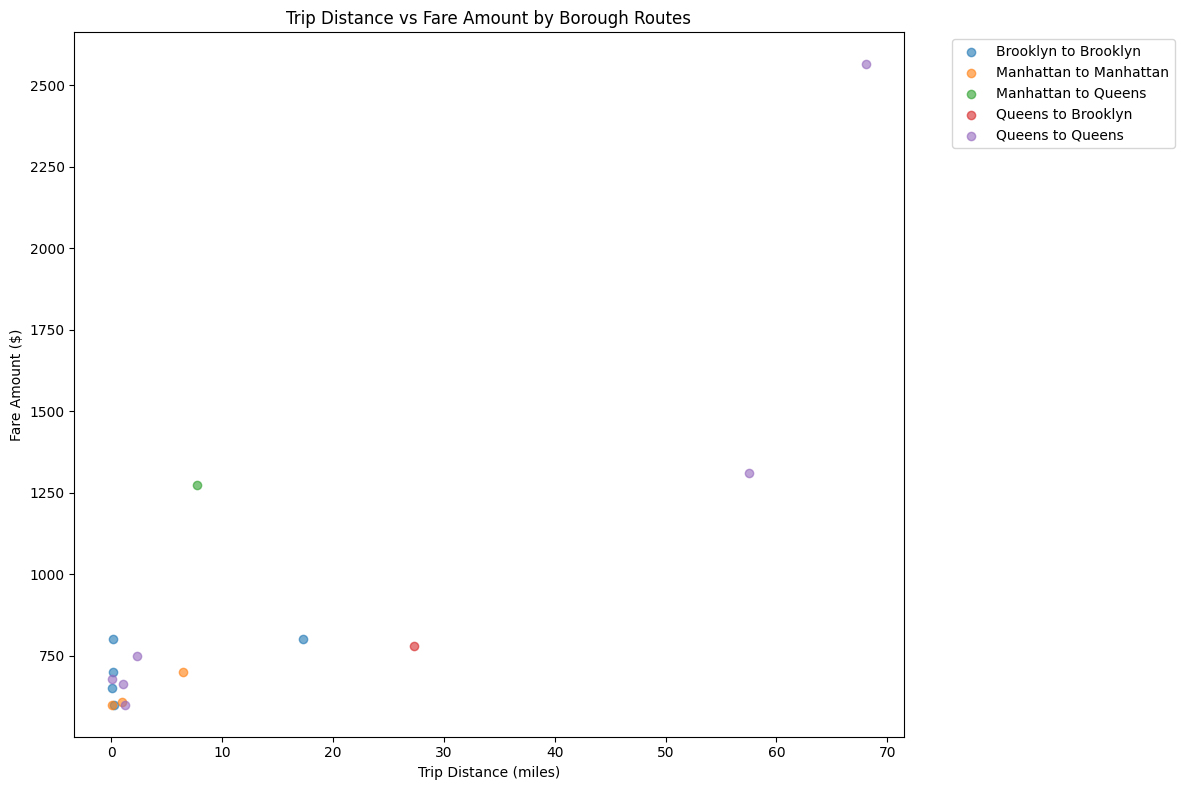

In [27]:
plot_distance_vs_fare(filtered_df)

In [23]:
short_trips = cleaned_df[cleaned_df['trip_distance'] <= 0.01]
short_trips_not_in_same_zone = short_trips[short_trips['PULocationID'] != short_trips['DOLocationID']]
short_trips_not_same_borough = short_trips_not_in_same_zone[short_trips_not_in_same_zone['Borough_do_zone'] != short_trips_not_in_same_zone['borough']]

short_trips_not_in_same_zone[['PULocationID', 'DOLocationID']].value_counts()

PULocationID  DOLocationID
132           264             437
138           264             124
264           132             102
230           264              57
1             264              56
                             ... 
141           50                1
              75                1
              142               1
              161               1
158           234               1
Name: count, Length: 994, dtype: int64

In [24]:
cleaned_df.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee', 'trip_duration',
       'LocationID_do', 'Borough_do', 'Zone_do', 'service_zone_do',
       'LocationID_do_zone', 'Borough_do_zone', 'Zone_do_zone',
       'service_zone_do_zone'],
      dtype='object')

In [27]:
cleaned_df['Borough_do_zone'].value_counts()

Borough_do_zone
Manhattan        34672346
Queens            2109647
Brooklyn          1524470
Bronx              233924
Unknown            228124
EWR                106257
Staten Island        9666
Name: count, dtype: int64

In [29]:
taxi_csv = pd.read_csv("../data/taxi_zones.csv")
taxi_csv.columns

Index(['LocationID', 'Borough', 'Zone', 'service_zone'], dtype='object')

In [33]:
test = cleaned_df.merge(taxi_csv, left_on='PULocationID', right_on='LocationID', how='left', suffixes=("_XXX", "_YYY"))

In [34]:
set(test.columns).difference(cleaned_df.columns)

{'Borough', 'LocationID', 'Zone', 'service_zone'}

# TRAIN THE MODEL

# we need to create a model using tensorflow to best predict the data, we'll use the cleaned_df for it